In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier, Ridge, RidgeCV, Lasso, LassoCV
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score, balanced_accuracy_score, roc_auc_score
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
chronic_kidney_disease = fetch_ucirepo(id=336) 
  
# data (as pandas dataframes) 
X = chronic_kidney_disease.data.features 
y = chronic_kidney_disease.data.targets 

## Question 1 ###

I will predict the 'class' (response variable) using all other features as predictors to help make informed decisions on whether or not a patient has CKD based on hemopoetic and physical observations.

## Question 2 ##

In [4]:
print(chronic_kidney_disease.variables[['name','type']]) 

     name         type
0     age      Integer
1      bp      Integer
2      sg  Categorical
3      al  Categorical
4      su  Categorical
5     rbc       Binary
6      pc       Binary
7     pcc       Binary
8      ba       Binary
9     bgr      Integer
10     bu      Integer
11     sc   Continuous
12    sod      Integer
13    pot   Continuous
14   hemo   Continuous
15    pcv      Integer
16   wbcc      Integer
17   rbcc   Continuous
18    htn       Binary
19     dm       Binary
20    cad       Binary
21  appet       Binary
22     pe       Binary
23    ane       Binary
24  class       Binary


sg, al, and su should be in categorical format.
The rest of the numerical variables can be scaled.

In [5]:
cat_var = ['sg','al','su']
for var in cat_var:
    X.loc[:,var] = pd.Categorical(X[var])

In [6]:
print(X.dtypes)

age       float64
bp        float64
sg       category
al       category
su       category
rbc        object
pc         object
pcc        object
ba         object
bgr       float64
bu        float64
sc        float64
sod       float64
pot       float64
hemo      float64
pcv       float64
wbcc      float64
rbcc      float64
htn        object
dm         object
cad        object
appet      object
pe         object
ane        object
dtype: object


I can use float64 to select all the numerical columns to scale.

In [7]:
scale_col = X.select_dtypes(include='float64').columns

In [8]:
scaler = StandardScaler()
X.loc[:,scale_col] = scaler.fit_transform(X[scale_col])

Now I can convert the binary strings into 0 or 1 integers. But the dm column has a formatting issue, I will convert it '\tno' into NaN.

In [9]:
print(X['dm'].unique())

['yes' 'no' '\tno' nan]


In [10]:
dict = {'normal':0,'notpresent':0,'no':0,'good':0,
        'abnormal':1,'present':1,'yes':1,'poor':1, '\tno':None,
       'notckd':0,'ckd':1}
X = X.replace(dict)

## Question 3 ##

In [11]:
X.describe()

,age,bp,rbc,pc,pcc,ba,bgr,bu,sc,sod,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
count,3.910000e+02,3.880000e+02,248.000000,335.000000,396.000000,396.000000,3.560000e+02,3.810000e+02,383.000000,3.130000e+02,...,3.480000e+02,3.290000e+02,2.940000e+02,2.690000e+02,398.000000,397.000000,398.000000,399.000000,399.000000,399.000000
mean,9.994847e-17,-2.380684e-16,0.189516,0.226866,0.106061,0.055556,-1.796316e-16,-3.729883e-17,0.000000,2.270105e-17,...,4.083579e-17,1.295823e-16,1.450087e-16,8.452553e-16,0.369347,0.345088,0.085427,0.205514,0.190476,0.150376
std,1.001281e+00,1.001291e+00,0.392711,0.419431,0.308305,0.229351,1.001407e+00,1.001315e+00,1.001308,1.001601e+00,...,1.001440e+00,1.001523e+00,1.001705e+00,1.001864e+00,0.483235,0.475997,0.279868,0.404584,0.393170,0.357888
min,-2.885708e+00,-1.936857e+00,0.000000,0.000000,0.000000,0.000000,-1.591967e+00,-1.108830e+00,-0.466102,-1.280094e+01,...,-3.241109e+00,-3.329218e+00,-2.111312e+00,-2.547777e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-5.530393e-01,-4.733701e-01,0.000000,0.000000,0.000000,0.000000,-6.193803e-01,-6.032459e-01,-0.378897,-2.433340e-01,...,-7.655198e-01,-7.669527e-01,-6.484596e-01,-7.889609e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.050779e-01,2.583733e-01,0.000000,0.000000,0.000000,0.000000,-3.414983e-01,-3.058433e-01,-0.309133,4.534651e-02,...,4.248496e-02,1.242700e-01,-1.381622e-01,9.044717e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.590867e-01,2.583733e-01,0.000000,0.000000,0.000000,0.000000,1.890038e-01,1.700008e-01,-0.047519,4.302539e-01,...,8.504897e-01,6.812843e-01,4.741947e-01,6.767192e-01,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,2.246163e+00,7.575807e+00,1.000000,1.000000,1.000000,1.000000,4.319341e+00,6.613723e+00,12.719271,2.451017e+00,...,1.813219e+00,1.683910e+00,6.121486e+00,3.217231e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


There are four indicated data types in the dataset: integer, continuous, binary, and categorical. When converted into a pandas dataframe, these types become float64, float64, int64, and category, respectively.
There are 400 total patients in this study, but there are missing data in all of the predictors. There is an uneven distribution in terms of the y variable, where there are 62% healthy patients and 38% patients with ckd.

## Question 4 ##

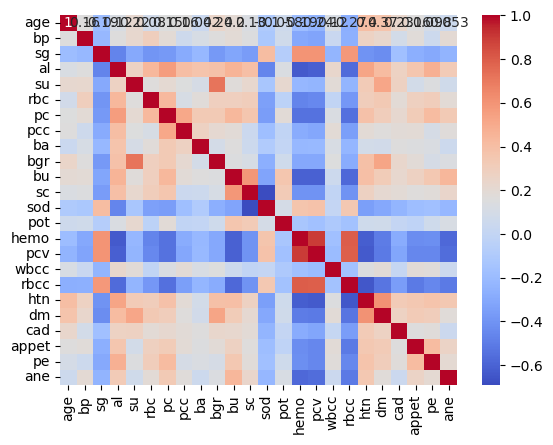

In [12]:
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.show()

There seem to be strong positive linear relationships/correlations between pcv/hemo, hemo/rbcc, and pcv/rbcc.
There also seem to be strong negative correlations for rbcc, hemo, and pcv.

The variables showing a strong correlation may be redundant in linearly predicting the response as they behave similarly in terms of the effects, one of the features in the pair may be excluded to avoid multicolinearity.

In contrast, those with weak correlations near 0 will act independently and are more likely to be retained during feature selection.

## Question 5 ##

In [13]:
print(X.isna().sum() / X.shape[0])

age      0.0225
bp       0.0300
sg       0.1175
al       0.1150
su       0.1225
rbc      0.3800
pc       0.1625
pcc      0.0100
ba       0.0100
bgr      0.1100
bu       0.0475
sc       0.0425
sod      0.2175
pot      0.2200
hemo     0.1300
pcv      0.1775
wbcc     0.2650
rbcc     0.3275
htn      0.0050
dm       0.0075
cad      0.0050
appet    0.0025
pe       0.0025
ane      0.0025
dtype: float64


In [14]:
print(y.isna().any())

class    False
dtype: bool


The response variable has no NaN's but many of the predictors have a large proportion of NaN's (up to 38%). I do not want to lose too much data, so I will aim to impute numerical entries with means and the categorical entries with the most frequent observation column-wise.

In [15]:
num_col = X.select_dtypes('number').columns

X_num_imp = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X[num_col])
X_cat_imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(X[cat_var])
X.loc[:,num_col] = X_num_imp
X.loc[:,cat_var] = X_cat_imp

In [16]:
sum(X.isna().any())

0

There is no loss of observations.

## Question 6 ##

In [17]:
Q3 = X[scale_col].quantile(0.75)
Q1 = X[scale_col].quantile(0.25)
IQR = Q3-Q1
up_threshold = Q3 + IQR*2
low_threshold = Q1 - IQR*2

I want to replace the values outside this range with the thresholds. For tree-based algorithms, it is best to deal with outliers as they can skew the results.

In [18]:
np.sum((X[scale_col]>up_threshold) | (X[scale_col]<low_threshold), axis=0)

age      0
bp       6
bgr     41
bu      35
sc      31
sod     13
pot      7
hemo     1
pcv      1
wbcc    12
rbcc    42
dtype: int64

In [19]:
up_outliers = X[scale_col]>up_threshold
low_outliers = X[scale_col]<low_threshold

In [20]:
for col in scale_col:
    X.loc[:,col] = np.where(X[col]>up_threshold.loc[col], 
                            up_threshold.loc[col], X.loc[:,col])
    X.loc[:,col] = np.where(X[col]<low_threshold.loc[col], 
                            low_threshold.loc[col], X.loc[:,col])

## Question 7 ##

In [21]:
%%capture

sil = []
for i in range(2,10) :
    km = KMeans(n_clusters=i+1, n_init=20, random_state=0)
    cluster_labels_km = km.fit_predict(X)
    sil.append(silhouette_score(X, cluster_labels_km).round(3))

In [22]:
print(sil)

[0.262, 0.223, 0.237, 0.137, 0.131, 0.138, 0.128, 0.131]


From the average silhouette scores from K=2 to 10, we can see that K=2 is the best choice of clusters.

In [23]:
%%capture

km2 = KMeans(n_clusters=2, n_init=20, random_state=0)
cluster_labels_km2 = np.where(km2.fit_predict(X)==0,'red','blue')

In [24]:
pca = PCA()
X_pca = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

[3.79388730e-01 1.20758941e-01 1.12481506e-01 7.44844122e-02
 6.29226009e-02 4.96526023e-02 2.92513034e-02 2.44762249e-02
 2.17666414e-02 1.80360311e-02 1.62475469e-02 1.37655572e-02
 1.20121723e-02 1.03802387e-02 9.88934233e-03 9.03458549e-03
 7.66271730e-03 7.04594857e-03 5.54925793e-03 4.27204699e-03
 3.91983811e-03 3.75233742e-03 3.24774349e-03 1.67447307e-06]


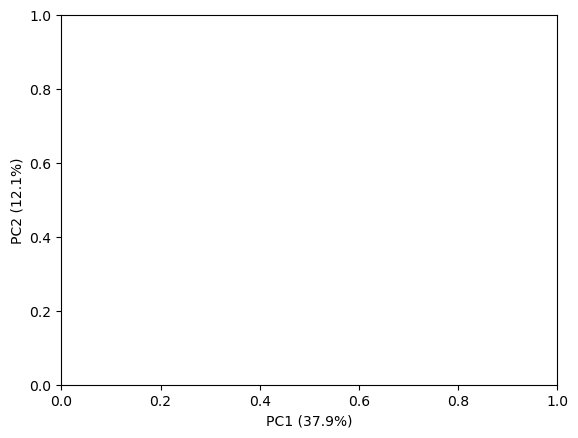

In [25]:
for i in range(len(X_pca)):
    if y.values.ravel()[i] == 0:
        plt.scatter(X_pca[i, 0], X_pca[i, 1], c=cluster_labels_km2[i], marker='o', alpha=0.5)
    elif y.values.ravel()[i] == 1:
        plt.scatter(X_pca[i, 0], X_pca[i, 1], c=cluster_labels_km2[i], marker='^', alpha=0.5)

plt.xlabel('PC1 (37.9%)')
plt.ylabel('PC2 (12.1%)')
plt.show()

The blue points belong to cluster 1 while the red points belong to cluster 2. The circles represent ckd while the triangles represent not ckd.

## Question 8 ##

In [26]:
print((y=='ckd').sum()/y.shape[0])

class    0.62
dtype: float64


The response classes are split 62% and 38%. It is moderately imbalanced, so I will stratify y when splitting.

In [27]:
print(y.stack().unique())

['ckd' 'ckd\t' 'notckd']


There is also a typo in the response variable. I will replace 'ckd\t' with 'ckd'. ckd will be 1, while notckd will be 0.

In [28]:
y = np.where(y=='ckd\t', 'ckd', y)
y = pd.DataFrame(y).replace(dict)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size=0.3, random_state=1, stratify=y)

In [30]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

## Question 9 ##

I want to compare the performance of linear models (ridge and lasso models) in classifying the ckd patients. The number of observations in the dataset is only 400, and there are not too many predictors. Linear models could be suitable for this dataset with quick computational times. I can also use the feature selection provided by lasso to further optimize the model and compare with ridge, which doesn't have built-in feature selection.

In [31]:
rc = Ridge().fit(X_train, y_train)
ls = Lasso().fit(X_train, y_train)

## Question 10 ##

Accuracy/balanced accuracy: measures the proportion of correctly classified instances out of the total number of instances. Higher accuracy indicates better performance and classification.

MSE: an absolute measure of the errors between the predicted and test values. Lower value indicated better performance.

## Question 11 ##

- Feature importance coefficients from LASSO
- Directly estimate alpha scores with cross-validation for linear model

In [32]:
rc_cv = RidgeCV(alphas=np.logspace(-4, 4, 100), cv=10).fit(X_train, y_train)
rc_alpha = rc_cv.alpha_

ls_cv = LassoCV(alphas=np.logspace(-4, 4, 100), cv=10).fit(X_train, y_train)
ls_alpha = ls_cv.alpha_

In [33]:
rc1 = Ridge(alpha=rc_alpha).fit(X_train, y_train) 
ls1 = Lasso(alpha = ls_alpha).fit(X_train, y_train)

In [34]:
ls_keep = X_train.columns[ls1.coef_!=0]

In [35]:
ls2 = Lasso(alpha = ls_alpha).fit(X_train[ls_keep], y_train)

## Question 12 ##

In [36]:
ls2_pred = np.where(ls2.predict(X_test[ls_keep]) >= 0.5, 1, 0) # have to round predictions
rc1_pred = np.where(rc1.predict(X_test) >= 0.5, 1, 0)

print(balanced_accuracy_score(y_test, ls2_pred),
      balanced_accuracy_score(y_test, rc1_pred))

0.9866666666666667 0.9933333333333334


In [37]:
print(np.sqrt(metrics.mean_squared_error(y_test, ls2_pred)))
print(np.sqrt(metrics.mean_squared_error(y_test, rc1_pred)))

0.12909944487358055
0.09128709291752768


The ridge classifier had very optimized performance using the test set(high accuracy and low MSE), but it still had some misclassifications. Meanwhile, the lasso model had a lower accuracy and higher MSE than the ridge classifier. The ridge classifier is more robust and optimized.

## Question 13 ##

In [39]:
rc2 = RidgeClassifier(alpha = rc_alpha).fit(X, y.values.ravel())
rc2_feature_df = pd.DataFrame({'Feature': X.columns, 
                              'Coefficient': rc2.coef_.reshape(len(X.columns))})
rc2_feature_df

,Feature,Coefficient
0,age,-0.006322
1,bp,0.048400
2,sg,-45.945437
3,al,0.049555
4,su,-0.001235
5,rbc,0.337131
6,pc,-0.008348
7,pcc,-0.055386
8,ba,-0.162739
9,bgr,0.093600


The greater the coefficient (absolute value) of the predictors, the more influence it exerts on the predictive process of the model. Vice versa for smaller coefficients, where the predictor does not influence the predictions as much. The predictors with smaller coefficients (below a certain threshold) of the ridge classifier could possibly be eliminated to reduce noise and computation time. The sign of the coefficient indicates the relationship between the predictor and the predicted variable: negative means that there is an inverse relationship, and vice versa. For example, an increase in the sg coefficient (-45) means that it will strongly lead a decrease in the result (not ckd or 0).

## Question 14 ##

We can use the predicted subgroup labels using K=2 clustering as a predictor along side the other features.

In [40]:
%%capture

X1 = X
X1['subgroup'] = km2.fit_predict(X1)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, 
    test_size=0.3, random_state=1, stratify=y)

In [41]:
ls3_cv = LassoCV(alphas=np.logspace(-4, 4, 100), cv=10).fit(X_train1, y_train1.values.ravel())
ls3_alpha = ls3_cv.alpha_

In [42]:
ls3 = Lasso(alpha = ls3_alpha).fit(X_train1, y_train1.values.ravel())
ls3_keep = X_train1.columns[ls3.coef_!=0]

In [43]:
ls4 = Lasso(alpha = ls3_alpha).fit(X_train1[ls3_keep], y_train1.values.ravel())

In [44]:
ls4_pred = np.where(ls4.predict(X_test1[ls3_keep]) >= 0.5, 1, 0)

print(balanced_accuracy_score(y_test1, ls4_pred))
print(np.sqrt(metrics.mean_squared_error(y_test1, ls4_pred)))

0.9866666666666667
0.12909944487358055


Unfortunately, the performance of the model remained constant with the addition of this feature. Perhaps the additional feature added noise to the model.

## Question 16 ##

https://github.com/jlhjiang/stats3da3_hw6